На этом семинаре необходимо будет (1) реализовать простейшую metric learning архитектуру на основе сиамской нейросети с Contrastive Loss и использовать ее для поиска похожих изображений (2) реализовать fully convolutional сеть для задачи image super-resolution. 

# Metric Learning (0.7 балла)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import Sampler, BatchSampler
from torch.nn.modules.loss import MSELoss

Вам необходимо реализовать вычисление Contrastive Loss - одну из самых популярных функций потерь для metric learning. Contrastive Loss получает на вход пару векторов $x_i$ и $x_j$ и метку $y_{ij}$, причем $y_{ij} = 0$, если объекты "похожи" (принадлежат одному классу), и $y_{ij} = 1$, если объекты "различны" (принадлежат различным классам). Формально определим Contrastive Loss следующим образом:

$$
L(x_i, x_j, y_{ij}) = (1 - y_{ij})\|x_i - x_j\|^2 + y_{ij}max(0, m - \|x_i - x_j\|^2)
$$

где $m$ - гиперпараметр (его можно взять равным единице).

Вместо того, чтобы формировать обучающее множество из всевозможных пар, можно поступить проще: будем пропускать батч из $N$ обучаюших изображений через сеть (тем самым получая соответствующие векторы $x$), а значение лосса вычислять как среднее значение функции $L$ на всех парах в этом батче. Тогда в обучении на каждом батче участвует $\frac{N(N-1)}{2}$ пар, что существенно ускоряет сходимость на практике. Реализуйте предложенный вариант Contrastive Loss.

In [0]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x, y):
        #<your code>
        # y_i,j = 0, если x_i, x_j одного класса и 1 иначе
        bs = y.size()[0]
        xij = torch.matmul(x,x.transpose(0,1))
        norms = torch.sum(x * x, 1)
        
        row = y.view(1,bs).expand((bs,bs))
        col = y.view(bs,1).expand((bs,bs))
        yij = 1.0 - torch.eq(row,col).float()
        
        dij = norms.view(bs,1).expand((bs,bs)) + norms.view(1,bs).expand((bs,bs)) - 2.0 * xij
        very_loss = (1 - yij) * dij + yij * F.relu(self.margin - dij)       
        loss = torch.sum(very_loss)
        return loss / bs / bs

В задачах metric learning, как правило, необходимо, чтобы количества "положительных" и "отрицательных" пар в обучении отличалось несильно. Поэтому в случае большого количества классов случайное формирование батчей неэффективно - в таком случае количество "положительных" пар очень мало. Поэтому будем формировать обучающие батчи размера $N$ следующим образом: будем брать $\frac{N}{2}$ элементов из некоторого класса (они между собой будут формировать "положительные пары"), а оставшиеся $\frac{N}{2}$ элементов будем брать случайно. Таким образом мы гарантируем, что в каждом обучающем батче будет достаточно "положительных" пар.

Реализуйте предложенную логику в рамках Pytorch, реализовав собственный BatchSampler. Ваш самплер должен формировать каждый батч размера $N$ следующим образом: $\frac{N}{2}$ объектов извлекаются из некоторого случайного класса, оставшиеся $\frac{N}{2}$ объектов извлекаются случайно.

In [0]:
from collections import defaultdict
class ContrastiveSampler(BatchSampler):
    def __init__(self, batch_size, num_classes, labels):
        self.num_classes = num_classes
        self.imgs_per_class = labels.size()[0] // num_classes
        #<your code>
        class2idx = defaultdict(list)
        for i, y in enumerate(labels):
            class2idx[y].append(i)
        self.batch_size = batch_size
        self.class2idx = class2idx
        self.total_samples = len(labels)

    def __iter__(self):
        num_yielded = 0
        while num_yielded < (self.num_classes * self.imgs_per_class):
            batch = []
            #<your code>
            base = np.random.randint(0,self.num_classes)
            pos = np.random.choice(self.class2idx[base], size = self.batch_size // 2).tolist()
            neg = np.random.randint(self.total_samples, size = self.batch_size // 2).tolist()
            batch.extend(pos)
            batch.extend(neg)
            
            num_yielded += self.batch_size
            yield torch.from_numpy(np.array(batch))

В этом задании будем работать с небольшими изображениями одежды из датасета Fashion-MNIST.

In [0]:
input_size = 784
num_classes = 10
batch_size = 256

train_dataset = dsets.FashionMNIST(root='.', 
                                   train=True, 
                                   transform=transforms.ToTensor(),
                                   download=True)

test_dataset = dsets.FashionMNIST(root='.', 
                                  train=False, 
                                  transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_sampler=ContrastiveSampler(batch_size=batch_size, num_classes=num_classes, labels=train_dataset.train_labels), 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_sampler=ContrastiveSampler(batch_size=batch_size, num_classes=num_classes, labels=test_dataset.test_labels), 
                                          shuffle=False)

Реализуйте сеть несложной архитектуры, содержащую три сверточных слоя из 20 фильтров с макс-пулингом, а также два полносвязных слоя из 128 нейронов. Выход последнего слоя будет подаваться на вход Contrastive Loss.

In [0]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

class ContrastiveNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Sequential(
            #<your code>
            # проверить одинакове ли ПАРАМЕТРЫ СОГЛАСНО УСЛОВИЮ
        nn.Conv2d(1, 20, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(20, 20, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(20, 20, kernel_size=3),
        nn.ReLU(),
        Flatten(),
        nn.Linear(180, 128),
        nn.ReLU(),
        nn.Linear(128, 128)
        )

    def forward(self, x):
        output = self.cnn1(x)
        return output

In [0]:
contrastive_loss = ContrastiveLoss()

def train_epoch(model, optimizer):
    loss_log = []
    model.train()
    for batch_num, (x_batch, y_batch) in enumerate(train_loader):
        data = Variable(x_batch)
        target = Variable(y_batch)
        optimizer.zero_grad()
        output = model(data)        
        loss = contrastive_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.data[0]
        loss_log.append(loss)
    return loss_log   

def test(model):
    loss_log = []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):    
        data = Variable(x_batch)
        target = Variable(y_batch)
        output = model(data)
        loss = contrastive_loss(output, target)
        loss = loss.data[0]
        loss_log.append(loss)
    return loss_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)    
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log = []
    val_log = []

    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt)
        val_loss = test(model)
        train_log.extend(train_loss)
        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        clear_output()
        plot_history(train_log, val_log)    

In [0]:
model = ContrastiveNetwork()

Обучите сеть с параметрами, указанными ниже.

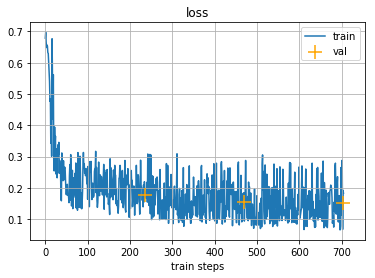

In [0]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
train(model, opt, 3)

Извлеките векторные описания тестовых изображений (a.k.a эмбеддинги). У вас должно получиться 10000 128-мерных векторов.

In [0]:
data = test_dataset.test_data 
embeddings = model(Variable(data.view(-1,1,28,28)).float())

Код ниже демонстрирует поисковую выдачу для трех изображений-запросов. Выдача формируется на основе близости эмбеддингов.

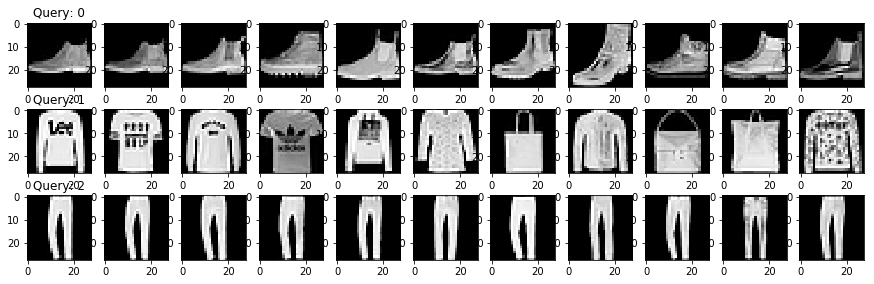

In [0]:
queryCount = 3
queries = embeddings[:queryCount,:].data.numpy()
database = embeddings[queryCount:,:].data.numpy()
plt.figure(figsize=[15, 4.5])
for i in range(queryCount):    
    results = np.argsort(np.sum((database-queries[i,:])**2, axis=1))[:10]
    plt.subplot(queryCount, 11, i * 11 + 1)
    plt.title("Query: %i" % i)
    plt.imshow(test_dataset.test_data[i].numpy().reshape([28, 28]), cmap='gray')
    for k in range(10):
        plt.subplot(queryCount, 11, i * 11 + k + 2)
        plt.imshow(test_dataset.test_data[results[k]+queryCount].numpy().reshape([28, 28]), cmap='gray')

### Тест на семинре

1469 0.0


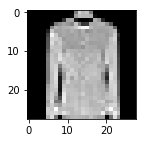

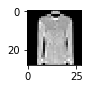

5685 48.1243


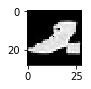

3541 54.571


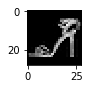

8584 61.7571


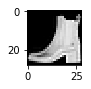

8074 62.8102


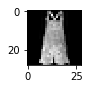

768 64.0328


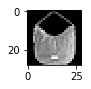

2701 74.0846


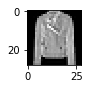

6687 76.3628


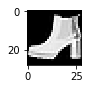

3247 81.3297


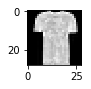

2002 81.9848


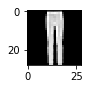

2020 0.0


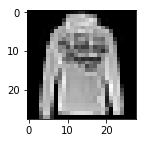

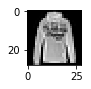

4020 14.5096


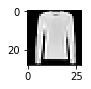

8778 25.6306


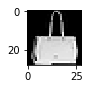

4392 33.7712


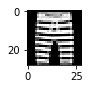

2310 37.3562


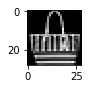

542 39.272


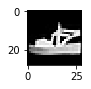

7181 40.8596


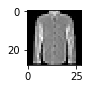

9065 43.5296


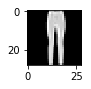

3737 50.5046


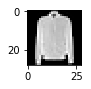

1911 53.2492


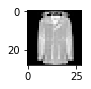

1401 0.0


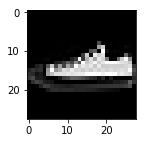

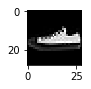

8253 26.5828


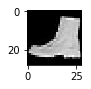

3391 27.7404


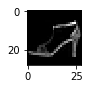

5814 35.9239


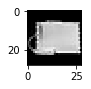

7427 39.2157


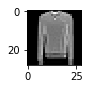

8923 40.1284


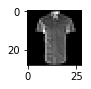

1384 40.9853


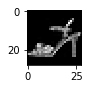

1392 41.4786


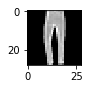

9083 42.0326


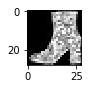

5326 46.0391


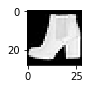

In [0]:
queryCount = 3
# queries = embeddings[:queryCount,:].data.numpy()
database = embeddings[queryCount:,:].data.numpy()
plt.figure(figsize=[15, 4.5])
for i in range(queryCount):
    base = np.random.randint(len(embeddings))
    plt.figure(figsize=(2,2))
    plt.imshow(data[base].numpy().reshape([28,28]), cmap='gray')
    
    dists = np.sum((database - database[base, ...]) ** 2, axis=1)
    results = np.argsort(dists)[:10]
    
    for j in results:
        print(j,dists[j])
        plt.figure(figsize=(1,1))
        plt.imshow(data[j].numpy().reshape([28,28]), cmap='gray')
        plt.show()
    
#     results = np.argsort(np.sum((database-queries[i,:])**2, axis=1))[:10]
#     plt.subplot(queryCount, 11, i * 11 + 1)
#     plt.title("Query: %i" % i)
#     plt.imshow(test_dataset.test_data[i].numpy().reshape([28, 28]), cmap='gray')
#     for k in range(10):
#         plt.subplot(queryCount, 11, i * 11 + k + 2)
#         plt.imshow(test_dataset.test_data[results[k]+queryCount].numpy().reshape([28, 28]), cmap='gray')

# Super-resolution (0.3 балла)

В этой части вам предстоит реализовать простейшую архитектуру для решения задачи image super-resolution.

In [0]:
input_size = 784
num_classes = 10
batch_size = 256

train_dataset = dsets.MNIST(root='./MNIST/', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./MNIST/', 
                           train=False, 
                           transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size,         
                                          shuffle=False)

Processing...
Done!


Мы будем увеличивать изображения размера (14,14) в два раза по каждому измерению. Как правило, перед подачей на вход нейросети изображение низкого разрешения увеличивают до нужного размера билинейной интерполяцией, а нейросеть улучшает результат интерпляции, не меняя пространственные размеры изображения.

Реализуйте нейросеть из трех сверточных слоев, которая будет получать на вход черно-белое изображение и выдавать на выход изображение такого же размера. Нейросеть должна предсказывать добавку, которую необходимо прибавить к полученному на вход изображению низкого качества. 

In [0]:
class SuperResolutionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Sequential(
            #<your code>
        nn.Conv2d(1, 20, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(20, 20, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(20, 20, kernel_size=3),
        nn.ReLU(),
        Flatten(),
        nn.Linear(180, 128),
        nn.ReLU(),
        nn.Linear(128, 784)
        )

    def forward(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], 1, 28, -1) #batch_size, num_channels, ширина картинки, длина картинки
        #print(output.shape)
        #print(x.shape)
        return output + x

In [0]:
model = SuperResolutionNetwork()

In [0]:
def low_res_and_high_res(images_batch):
    result = images_batch.clone()
    low_res_transform = transforms.Resize((14,14))
    high_res_transform = transforms.Resize((28,28))
    toTensorTransform = transforms.ToTensor()
    toImageTransform = transforms.ToPILImage()
    for i in range(images_batch.size()[0]):
        result[i] = toTensorTransform(high_res_transform(low_res_transform(toImageTransform(images_batch[i]))))
    return result

def train_epoch(model, optimizer, batchsize=32):
    loss_log = []
    model.train()
    for batch_num, (x_batch, y_batch) in enumerate(train_loader):
        x_batch = x_batch.float() / 255
        data = Variable(low_res_and_high_res(x_batch))
        target = Variable(x_batch)
        optimizer.zero_grad()
        output = model(data)        
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.data.cpu()[0]
        loss_log.append(loss)
    return loss_log   

def test(model):
    loss_log = []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):    
        x_batch = x_batch.float() / 255
        data = Variable(low_res_and_high_res(x_batch))
        target = Variable(x_batch)
        output = model(data)
        loss = F.mse_loss(output, target)        
        loss = loss.data.cpu()[0]
        loss_log.append(loss)
    return loss_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log = []
    val_log = []
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt, batchsize=batch_size)
        val_loss = test(model)
        train_log.extend(train_loss)
        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        clear_output()
        plot_history(train_log, val_log)    

Оптимизируйте сеть с параметрами, указанными ниже.

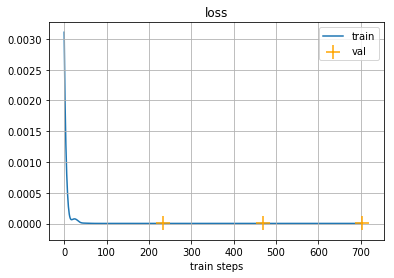

In [0]:
opt = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.05)
train(model, opt, 3)

In [0]:
test_images = test_dataset.test_data.float() / 255
result_cnn = model(Variable(low_res_and_high_res(test_images.view(-1,1,28,28))))

Код ниже визуализирует исходные изображения (28,28) и реконструкции, полученные с помощью нейросети.
Не удивляйтесь, есть качество реконструкций покажется низким, скоро вы узнаете, что MSE-loss, который мы использовали при обучении, не является оптимальным для задачи super-resolution (гораздо лучше работают adversarial-сети, про которые вам расскажут через пару недель).

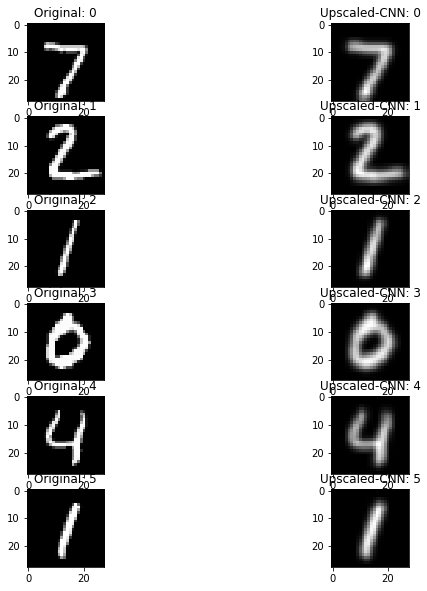

In [0]:
examplesCount = 6
plt.figure(figsize=[10, 10])
for i in range(examplesCount):
    plt.subplot(examplesCount, 2, i * 2 + 1)
    plt.title("Original: %i" % i)
    plt.imshow(test_dataset.test_data[i].numpy().reshape([28, 28]), cmap='gray')
    plt.subplot(examplesCount, 2, i * 2 + 2)
    plt.title("Upscaled-CNN: %i" % i)
    plt.imshow(result_cnn[i].data.numpy().reshape([28, 28]), cmap='gray')